# Plots for the presentation (Initial Training Results)

In [2]:
import importlib
from collections import OrderedDict

for pkg in ["pandas", "matplotlib", "seaborn", "wandb"]:
    spec = importlib.util.find_spec(pkg)
    print(f"{pkg}: {'FOUND ✅' if spec is not None else 'NOT FOUND ❌'}")


pandas: FOUND ✅
matplotlib: FOUND ✅
seaborn: FOUND ✅
wandb: FOUND ✅


In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")  # nicer plots



# Load WANDB_API_KEY from your file
env_path = "/Users/skothare/python/IDL_Fall2025/IDL-FInalProjectPlotting/wandb.env"  

if os.path.exists(env_path):
    with open(env_path) as f:
        for line in f:
            key, value = line.strip().split("=")
            os.environ[key] = value

print("Loaded WANDB_API_KEY:", "WANDB_API_KEY" in os.environ)

wandb.login(key=os.environ["WANDB_API_KEY"])

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/skothare/.netrc


Loaded WANDB_API_KEY: True


wandb: Currently logged in as: ssk-phl (Diffusion-F25DL_Project) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from collections import OrderedDict

run_paths = OrderedDict({
    "ddpm+vae"      : "Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x",
    "ddpm+cfg"      : "Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b",
    "ddpm+vae+cfg"  : "Diffusion-F25DL_Project/ddpm/aujkiwqx",
    "ddpm"          : "Diffusion-F25DL_Project/ddpm/pu8h7znt",
    "ddim"          : "Diffusion-F25DL_Project/ddim/2fcddv4m",
    "ddim+vae+cfg"  : "Diffusion-F25DL_Project/ddim/ku8yhzgf",
})


In [17]:


api = wandb.Api()

path = "Diffusion-F25DL_Project/ddim/2fcddv4m"   # e.g. the ddim run
run = api.run(path)

rows = []
for row in run.scan_history():   # full, unsampled history
    rows.append(row)

hist = pd.DataFrame(rows)
print(hist.columns)
hist.head()


Index(['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch',
       'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean',
       'is_std'],
      dtype='object')


,_step,loss,_runtime,_timestamp,lr,epoch,train_loss_epoch_avg,val_loss,gen_images,fid,is_mean,is_std
0,0,0.998215,2.514087,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.551881,25.564585,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.316400,48.566823,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.232149,71.503153,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.188505,94.378534,1.764814e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
api = wandb.Api()

all_runs = {}

for label, path in run_paths.items():
    print(f"Fetching run: {label} -> {path}")
    run = api.run(path)

    # 1) get FULL history (no sampling)
    rows = []
    for row in run.scan_history():   # no keys filter so we don't drop anything
        rows.append(row)
    hist = pd.DataFrame(rows)

    print("  columns:", list(hist.columns))

    # 2) make sure we have an epoch-like column
    if "epoch" in hist.columns:
        epoch_col = "epoch"
    elif "_step" in hist.columns:
        epoch_col = "_step"
    else:
        print(f"  ⚠️ No 'epoch' or '_step' column in {path}, skipping")
        continue

    # 3) keep just what we need
    wanted_cols = [epoch_col, "fid", "is_mean", "is_std"]
    cols_present = [c for c in wanted_cols if c in hist.columns]

    df = hist[cols_present].copy()
    df = df.dropna(subset=[epoch_col])        # drop rows where epoch is NaN
    df = df[df["fid"].notna() | df["is_mean"].notna()]  # keep rows with metrics

    # normalize column name to 'epoch'
    if epoch_col != "epoch":
        df = df.rename(columns={epoch_col: "epoch"})

    df["model"] = label
    all_runs[label] = df

len(all_runs), list(all_runs.keys())


Fetching run: ddpm+vae -> Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']
Fetching run: ddpm+cfg -> Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']
Fetching run: ddpm+vae+cfg -> Diffusion-F25DL_Project/ddpm/aujkiwqx
  columns: ['_timestamp', 'lr', 'train_loss_epoch_avg', 'fid', 'loss', 'is_mean', 'val_loss', '_step', 'gen_images', 'epoch', 'is_std', '_runtime']
Fetching run: ddpm -> Diffusion-F25DL_Project/ddpm/pu8h7znt
  columns: ['lr', 'is_mean', 'val_loss', '_timestamp', 'fid', 'loss', 'epoch', '_runtime', '_step', 'is_std', 'gen_images', 'train_loss_epoch_avg']
Fetching run: ddim -> Diffusion-F25DL_Project/ddim/2fcddv4m
  columns: ['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'tra

(6, ['ddpm+vae', 'ddpm+cfg', 'ddpm+vae+cfg', 'ddpm', 'ddim', 'ddim+vae+cfg'])

In [19]:
for name, path in run_paths.items():
    run = api.run(path)
    df = run.history()  # no column filter on purpose
    print(f"\n=== {name} ({path}) ===")
    print(df.columns.tolist()[:40])  # show first ~40 columns



=== ddpm+vae (Diffusion-F25DL_Project/DiffusionRuns/0oyifo3x) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']

=== ddpm+cfg (Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'fid', 'is_mean', 'is_std', 'gen_images']

=== ddpm+vae+cfg (Diffusion-F25DL_Project/ddpm/aujkiwqx) ===
['_timestamp', 'lr', 'train_loss_epoch_avg', 'fid', 'loss', 'is_mean', 'val_loss', '_step', 'gen_images', 'epoch', 'is_std', '_runtime']

=== ddpm (Diffusion-F25DL_Project/ddpm/pu8h7znt) ===
['lr', 'is_mean', 'val_loss', '_timestamp', 'fid', 'loss', 'epoch', '_runtime', '_step', 'is_std', 'gen_images', 'train_loss_epoch_avg']

=== ddim (Diffusion-F25DL_Project/ddim/2fcddv4m) ===
['_step', 'loss', '_runtime', '_timestamp', 'lr', 'epoch', 'train_loss_epoch_avg', 'val_loss', 'gen_images', 'fid', 'is_mean', 'is_std']

=== ddim+v

In [20]:
for label, df in all_runs.items():
    print(label, "-> FID points:", df["fid"].notna().sum(),
                     "IS points:", df["is_mean"].notna().sum())
    display(df.head())


ddpm+vae -> FID points: 38 IS points: 38


,epoch,fid,is_mean,is_std,model
214,5.0,308.754700,1.908898,0.055059,ddpm+vae
430,10.0,302.828491,2.301769,0.126235,ddpm+vae
646,15.0,307.731018,2.388286,0.090379,ddpm+vae
862,20.0,306.427246,2.867938,0.251349,ddpm+vae
1078,25.0,283.797119,2.494602,0.117597,ddpm+vae


ddpm+cfg -> FID points: 9 IS points: 9


,epoch,fid,is_mean,is_std,model
85,5.0,149.578613,4.537992,0.240941,ddpm+cfg
301,10.0,157.029953,4.599422,0.237277,ddpm+cfg
517,15.0,170.181107,4.218221,0.163885,ddpm+cfg
733,20.0,156.917053,5.057308,0.351752,ddpm+cfg
949,25.0,165.822174,5.036327,0.254138,ddpm+cfg


ddpm+vae+cfg -> FID points: 176 IS points: 176


,epoch,fid,is_mean,is_std,model
42,1.0,176.246948,4.316242,0.231131,ddpm+vae+cfg
86,2.0,200.411041,4.022239,0.246911,ddpm+vae+cfg
130,3.0,202.710602,4.118558,0.297985,ddpm+vae+cfg
174,4.0,199.673874,4.254688,0.327249,ddpm+vae+cfg
218,5.0,212.537643,3.582687,0.186836,ddpm+vae+cfg


ddpm -> FID points: 88 IS points: 88


,epoch,fid,is_mean,is_std,model
42,1.0,205.153778,3.779884,0.316654,ddpm
86,2.0,208.406418,3.765404,0.218378,ddpm
130,3.0,211.712204,3.779976,0.312994,ddpm
174,4.0,215.076614,4.279099,0.299953,ddpm
218,5.0,214.957031,4.194093,0.248854,ddpm


ddim -> FID points: 18 IS points: 18


,epoch,fid,is_mean,is_std,model
214,5.0,150.108093,3.699886,0.245303,ddim
430,10.0,144.116623,4.081598,0.369921,ddim
646,15.0,157.533615,4.470495,0.164078,ddim
862,20.0,162.125137,3.605563,0.254060,ddim
1078,25.0,156.320206,4.514240,0.329404,ddim


ddim+vae+cfg -> FID points: 21 IS points: 21


,epoch,fid,is_mean,is_std,model
214,5.0,342.611755,2.691149,0.182383,ddim+vae+cfg
430,10.0,361.171356,2.955753,0.161611,ddim+vae+cfg
646,15.0,350.318848,2.674515,0.226769,ddim+vae+cfg
862,20.0,382.614502,3.828072,0.306196,ddim+vae+cfg
1078,25.0,348.118317,3.020753,0.311301,ddim+vae+cfg


In [23]:
combined_df = pd.concat(all_runs.values(), ignore_index=True)
combined_df.head()
combined_df[combined_df["fid"].notna()].head()


,epoch,fid,is_mean,is_std,model
0,5.0,308.754700,1.908898,0.055059,ddpm+vae
1,10.0,302.828491,2.301769,0.126235,ddpm+vae
2,15.0,307.731018,2.388286,0.090379,ddpm+vae
3,20.0,306.427246,2.867938,0.251349,ddpm+vae
4,25.0,283.797119,2.494602,0.117597,ddpm+vae


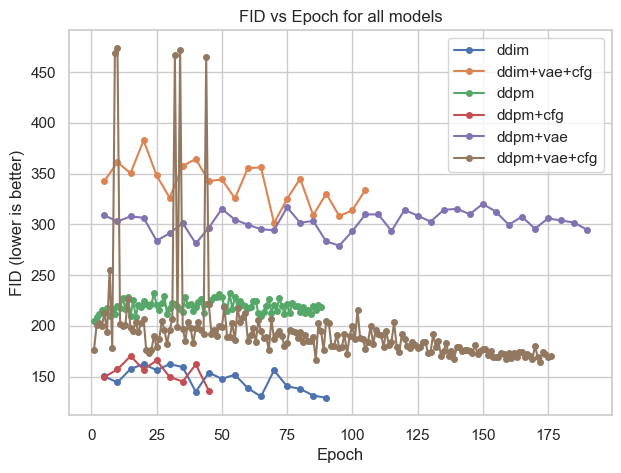

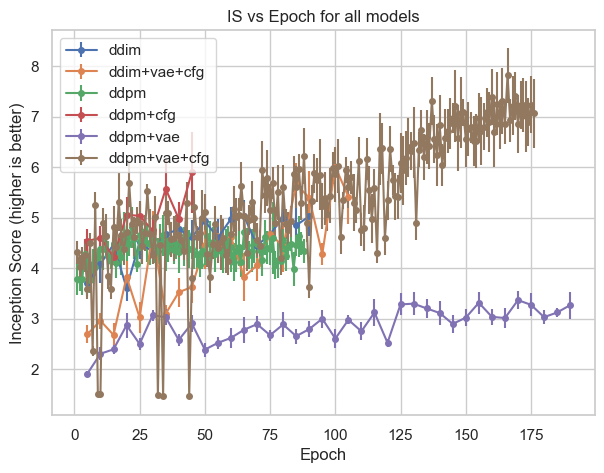

In [24]:


# FID vs epoch
plt.figure(figsize=(7,5))
for name, group in combined_df.groupby("model"):
    plt.plot(group["epoch"], group["fid"], marker="o", markersize=4, label=name)
plt.xlabel("Epoch")
plt.ylabel("FID (lower is better)")
plt.title("FID vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()

# IS vs epoch
plt.figure(figsize=(7,5))
for name, group in combined_df.groupby("model"):
    plt.errorbar(group["epoch"], group["is_mean"], yerr=group["is_std"], marker="o", markersize=4, label=name)
plt.xlabel("Epoch")
plt.ylabel("Inception Score (higher is better)")
plt.title("IS vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()


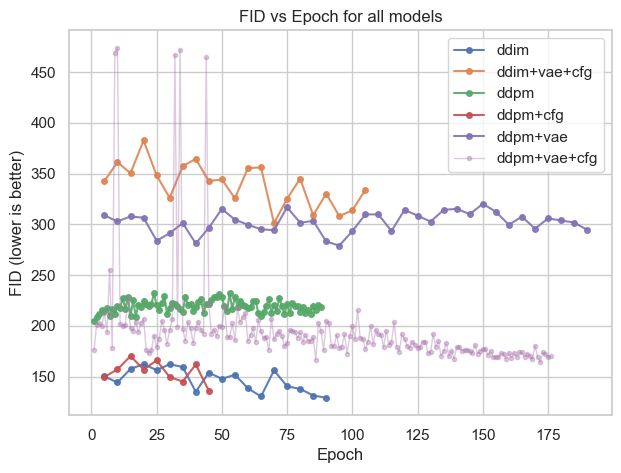

In [27]:
plt.figure(figsize=(7,5))

for name, group in combined_df.groupby("model"):

    # Custom lighter style for the heavy run
    if name == "ddpm+vae+cfg":
        plt.plot(
            group["epoch"],
            group["fid"],
            marker="o",
            markersize=3,
            alpha=0.4,                # lighten greatly
            linewidth=1.0,
            color="#ad78b08b",        
            label=name,
        )
    else:
        plt.plot(
            group["epoch"],
            group["fid"],
            marker="o",
            markersize=4,
            alpha=0.9,
            linewidth=1.5,
            label=name,
        )

plt.xlabel("Epoch")
plt.ylabel("FID (lower is better)")
plt.title("FID vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()


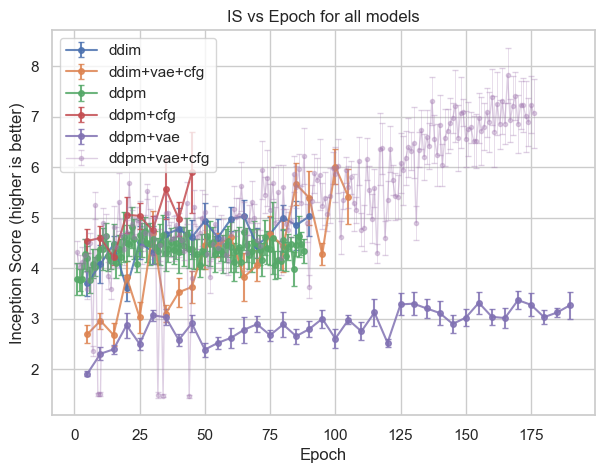

In [28]:
plt.figure(figsize=(7,5))

for name, group in combined_df.groupby("model"):

    # Special lighter styling for ddpm+vae+cfg (the heavy run)
    if name == "ddpm+vae+cfg":
        plt.errorbar(
            group["epoch"],
            group["is_mean"],
            yerr=group["is_std"],
            marker="o",
            markersize=3,
            alpha=0.35,               # very light curve
            linewidth=1.0,
            color="#a178b07f",  # light beige/brown
            elinewidth=0.5,
            capsize=2,
            label=name,
        )
    else:
        plt.errorbar(
            group["epoch"],
            group["is_mean"],
            yerr=group["is_std"],
            marker="o",
            markersize=4,
            alpha=0.85,
            linewidth=1.5,
            capsize=2,
            label=name,
        )

plt.xlabel("Epoch")
plt.ylabel("Inception Score (higher is better)")
plt.title("IS vs Epoch for all models")
plt.legend()
plt.grid(True)
plt.show()


# Final Training Results (Plots for Report)

In [1]:
!cd /jet/home/skothare/F25-Deep-Learning-Project

In [2]:
import importlib
from collections import OrderedDict

for pkg in ["pandas", "matplotlib", "seaborn", "wandb"]:
    spec = importlib.util.find_spec(pkg)
    print(f"{pkg}: {'FOUND ✅' if spec is not None else 'NOT FOUND ❌'}")


pandas: FOUND ✅
matplotlib: FOUND ✅
seaborn: FOUND ✅
wandb: FOUND ✅


In [3]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

env_path = "/jet/home/skothare/F25-Deep-Learning-Project/wandb.env"

if os.path.exists(env_path):
    with open(env_path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            # Remove leading 'export '
            if line.startswith("export "):
                line = line.replace("export ", "", 1)

            if "=" in line:
                key, value = line.split("=", 1)
                key = key.strip()
                value = value.strip()

                # NEW: strip surrounding single or double quotes
                if (value.startswith('"') and value.endswith('"')) or \
                   (value.startswith("'") and value.endswith("'")):
                    value = value[1:-1]

                os.environ[key] = value

print("Loaded WANDB_API_KEY:", "WANDB_API_KEY" in os.environ)
#print("Cleaned key:", repr(os.environ.get("WANDB_API_KEY")))



Loaded WANDB_API_KEY: True


In [4]:
from collections import OrderedDict

run_paths = OrderedDict({
    # Juhi's runs 
    "ddpm+vae+cfg": [
        "Diffusion-F25DL_Project/ddpm/aujkiwqx",# epochs ~1–177
        "Diffusion-F25DL_Project/ddpm/jvpwze94", # epochs ~178–200 (resumed) (true epochs on wandb: 1 through 23)
    ],
    "ddpm": [
        "Diffusion-F25DL_Project/ddpm/pu8h7znt",   # epochs ~1–88
        "Diffusion-F25DL_Project/ddpm/z3yi8j3a",
        "Diffusion-F25DL_Project/ddpm/atuz6gw9", # epochs ~90–... (resumed) (true epochs: 1-17 on wandb, but continuing from 89-105)
    ],

    # Divya's multi-block runs
    "ddpm+vae": [
        "Diffusion-F25DL_Project/DiffusionRuns/ugqmucs3", # 1 through 200 (single run)
    ],
    "ddpm+cfg": [
        "Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b",# block 1 epochs 4-79
        "Diffusion-F25DL_Project/DiffusionRuns/0wyv96om",# block 2 epochs 80-155
        "Diffusion-F25DL_Project/DiffusionRuns/qqu7eh2c",# block 3 epochs 155-200
    ],

    # Sumeet's single-run models
    "ddim": [
        "Diffusion-F25DL_Project/ddim/9hmn504q", # on wandb 1 through 159 epochs
    ],
    "ddim+vae+cfg": [
        "Diffusion-F25DL_Project/ddim/ku8yhzgf", # 1 through 186 epochs
    ],
    "dit+vae+cfg": [
        "Diffusion-F25DL_Project/dit/bneb2fzz", # 1 through 200
    ],
    "dit+vae+cfg_12h": [
        "Diffusion-F25DL_Project/dit/ajeuv0xj", # 1 through 169
    ],
    "dit_pixel": [
        "Diffusion-F25DL_Project/dit/wa1hl0of", # 1 through 64
    ],
})


In [5]:
import re
api = wandb.Api()

def fetch_history_single_run(path, verbose=False):
    """
    Load all history for a single run and return:
      epoch, fid, is_mean, is_std
    where fid/is_* columns are inferred from column names.
    """

    run = api.run(path)

    # Get full history (up to a big sample limit)
    hist = run.history(samples=10000)  # adjust if you somehow have more

    if verbose:
        print(f"\n=== columns for {path} ===")
        print(hist.columns.tolist())

    # 1) identify epoch-like column
    epoch_col = None
    for cand in ["epoch", "global_step", "_step", "trainer/global_step"]:
        if cand in hist.columns:
            epoch_col = cand
            break
    if epoch_col is None:
        raise ValueError(f"No epoch-like column found in {path}")

    # 2) infer FID / IS column names by substring
    def find_col(regex_list):
        for col in hist.columns:
            for pattern in regex_list:
                if re.search(pattern, col, re.IGNORECASE):
                    return col
        return None

    fid_col     = find_col([r"\bfid\b"])
    is_mean_col = find_col([r"is_mean", r"inception[_/ ]score", r"\bis\b"])
    is_std_col  = find_col([r"is_std", r"is-std", r"inception[_/ ]score_std"])

    if verbose:
        print("  chosen epoch_col:", epoch_col)
        print("  chosen fid_col:", fid_col)
        print("  chosen is_mean_col:", is_mean_col)
        print("  chosen is_std_col:", is_std_col)

    cols = [epoch_col]
    rename_map = {epoch_col: "epoch"}

    if fid_col is not None:
        cols.append(fid_col)
        rename_map[fid_col] = "fid"
    if is_mean_col is not None:
        cols.append(is_mean_col)
        rename_map[is_mean_col] = "is_mean"
    if is_std_col is not None:
        cols.append(is_std_col)
        rename_map[is_std_col] = "is_std"

    df = hist[cols].copy().rename(columns=rename_map)

    # Drop rows with no epoch
    df = df.dropna(subset=["epoch"])

    # Keep every row that has at least one of fid / is_mean
    metric_cols = [c for c in ["fid", "is_mean"] if c in df.columns]
    if metric_cols:
        df = df[df[metric_cols].notna().any(axis=1)]
    else:
        # no fid or is_mean at all; just return empty
        df = df.iloc[0:0]

    df = df.sort_values("epoch").reset_index(drop=True)

    if verbose:
        print("  df shape:", df.shape)
        print("  first few rows:\n", df.head())
        print("  last few rows:\n", df.tail())

    return df

In [6]:
stitched_runs = {}

for model_name, path_list in run_paths.items():
    print(f"\nProcessing model: {model_name}")
    prev_end = None
    seg_dfs = []

    for i, path in enumerate(path_list):
        df_seg = fetch_history_single_run(path)  # new robust version
        if df_seg.empty:
            print(f"  segment {i+1}: {path} -> no FID/IS rows, skipping")
            continue

        start = df_seg["epoch"].min()
        end   = df_seg["epoch"].max()
        print(f"  segment {i+1}: {path} (epochs {start}–{end})")

        if prev_end is None:
            df_adj = df_seg.copy()
        else:
            # Juhi-style restart: epochs go back near 1
            if start <= 2 or start <= prev_end:
                offset = prev_end
                df_adj = df_seg.copy()
                df_adj["epoch"] = df_adj["epoch"] + offset
                print(f"    -> detected restart, applying offset +{offset}")
            else:
                df_adj = df_seg
                print(f"    -> continuation, no offset")

        prev_end = df_adj["epoch"].max()
        seg_dfs.append(df_adj)

    if seg_dfs:
        df_full = pd.concat(seg_dfs, ignore_index=True)
        df_full["model"] = model_name
        stitched_runs[model_name] = df_full

combined_df = pd.concat(stitched_runs.values(), ignore_index=True)
print("\nCombined df shape:", combined_df.shape)



Processing model: ddpm+vae+cfg
  segment 1: Diffusion-F25DL_Project/ddpm/aujkiwqx (epochs 1.0–176.0)
  segment 2: Diffusion-F25DL_Project/ddpm/jvpwze94 (epochs 1.0–23.0)
    -> detected restart, applying offset +176.0

Processing model: ddpm
  segment 1: Diffusion-F25DL_Project/ddpm/pu8h7znt (epochs 1.0–88.0)
  segment 2: Diffusion-F25DL_Project/ddpm/z3yi8j3a (epochs 1.0–88.0)
    -> detected restart, applying offset +88.0
  segment 3: Diffusion-F25DL_Project/ddpm/atuz6gw9 (epochs 1.0–18.0)
    -> detected restart, applying offset +176.0

Processing model: ddpm+vae
  segment 1: Diffusion-F25DL_Project/DiffusionRuns/ugqmucs3 (epochs 5.0–200.0)

Processing model: ddpm+cfg
  segment 1: Diffusion-F25DL_Project/DiffusionRuns/sk56hw8b (epochs 5.0–75.0)
  segment 2: Diffusion-F25DL_Project/DiffusionRuns/0wyv96om (epochs 80.0–150.0)
    -> continuation, no offset
  segment 3: Diffusion-F25DL_Project/DiffusionRuns/qqu7eh2c (epochs 155.0–200.0)
    -> continuation, no offset

Processing model: 

In [7]:
for model, df in stitched_runs.items():
    print(f"\nSTITCHED MODEL: {model}")
    print("  epochs", df["epoch"].min(), "–", df["epoch"].max())
    print("  FID points:", df["fid"].notna().sum() if "fid" in df.columns else 0)
    print("  IS points:", df["is_mean"].notna().sum() if "is_mean" in df.columns else 0)



STITCHED MODEL: ddpm+vae+cfg
  epochs 1.0 – 199.0
  FID points: 199
  IS points: 199

STITCHED MODEL: ddpm
  epochs 1.0 – 194.0
  FID points: 194
  IS points: 194

STITCHED MODEL: ddpm+vae
  epochs 5.0 – 200.0
  FID points: 40
  IS points: 40

STITCHED MODEL: ddpm+cfg
  epochs 5.0 – 200.0
  FID points: 40
  IS points: 40

STITCHED MODEL: ddim
  epochs 5.0 – 155.0
  FID points: 31
  IS points: 31

STITCHED MODEL: ddim+vae+cfg
  epochs 5.0 – 185.0
  FID points: 37
  IS points: 37

STITCHED MODEL: dit+vae+cfg
  epochs 5.0 – 200.0
  FID points: 40
  IS points: 40

STITCHED MODEL: dit+vae+cfg_12h
  epochs 5.0 – 165.0
  FID points: 33
  IS points: 33

STITCHED MODEL: dit_pixel
  epochs 5.0 – 60.0
  FID points: 12
  IS points: 12


ddim num FID points plotted: 31
ddim+vae+cfg num FID points plotted: 37
ddpm num FID points plotted: 194
ddpm+cfg num FID points plotted: 40
ddpm+vae num FID points plotted: 40
ddpm+vae+cfg num FID points plotted: 199
dit+vae+cfg num FID points plotted: 40
dit+vae+cfg_12h num FID points plotted: 33
dit_pixel num FID points plotted: 12


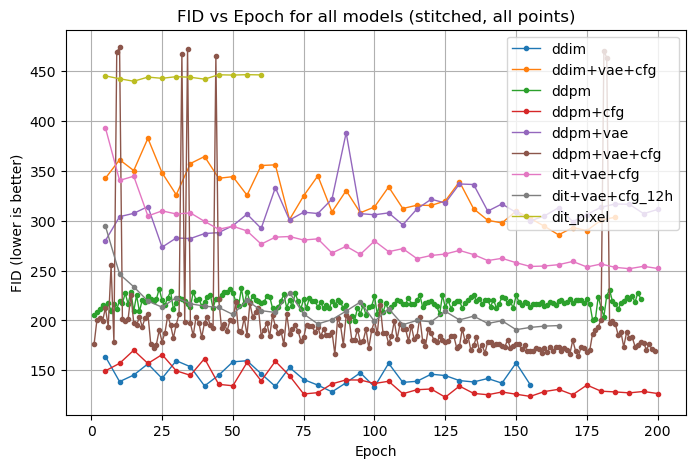

In [8]:
plt.figure(figsize=(8,5))
for name, group in combined_df.groupby("model"):
    g = group.sort_values("epoch")
    print(name, "num FID points plotted:", g["fid"].notna().sum())
    plt.plot(
        g["epoch"].values,
        g["fid"].values,
        marker="o",
        markersize=3,
        linewidth=1.0,
        label=name,
    )

plt.xlabel("Epoch")
plt.ylabel("FID (lower is better)")
plt.title("FID vs Epoch for all models (stitched, all points)")
plt.legend()
plt.grid(True)
plt.show()


In [53]:


# All model names (sorted for stable mappibgn)
all_models = sorted(combined_df["model"].unique())

# Define which models are DiT variants
dit_models = ["dit+vae+cfg", "dit+vae+cfg_12h", "dit_pixel"]

# Non-DiT models (first figure)
non_dit_models = [m for m in all_models if m not in dit_models]

# DiT + baseline comparison group
dit_plus_baselines = [
    "dit+vae+cfg_12h",
    "dit+vae+cfg",
    "dit_pixel",
    "ddim",
    "ddpm+cfg",
    "ddpm+vae+cfg",
]

# Distinct marker shapes to cycle through
marker_cycle = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', '>', '<', 'h', 'H']

# Map each model to a marker
marker_for_model = {
    model: marker_cycle[i % len(marker_cycle)]
    for i, model in enumerate(all_models)
}


In [54]:
# FID Score Plotter
def plot_fid_for_models(models, title, xlim=None):
    plt.figure(figsize=(15,5))
    mask = combined_df["model"].isin(models)

    for name, group in combined_df[mask].groupby("model"):
        g = group.sort_values("epoch")
        plt.plot(
            g["epoch"],
            g["fid"],
            marker=marker_for_model.get(name, 'o'),
            markersize=4,
            linewidth=1.4,
            alpha=0.9,
            label=name,
        )

    plt.xlabel("Epoch")
    plt.ylabel("FID (lower is better)")
    plt.title(title)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.grid(True, alpha=0.3)

    # Legend outside the plot area
    plt.legend(
        title="Model",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.,
    )
    # Leave room on the right for the legend
    plt.tight_layout(rect=[0, 0, 0.78, 1])
    plt.show()

# Inception Score Figure Plotter
def plot_is_for_models(models, title, xlim=None):
    plt.figure(figsize=(15,5))
    mask = combined_df["model"].isin(models)

    for name, group in combined_df[mask].groupby("model"):
        g = group.sort_values("epoch")
        plt.errorbar(
            g["epoch"],
            g["is_mean"],
            yerr=g["is_std"],
            marker=marker_for_model.get(name, 'o'),
            markersize=4,
            linewidth=1.4,
            capsize=2,
            alpha=0.9,
            label=name,
        )

    plt.xlabel("Epoch")
    plt.ylabel("Inception Score (higher is better)")
    plt.title(title)
    if xlim is not None:
        plt.xlim(*xlim)
    plt.grid(True, alpha=0.3)

    plt.legend(
        title="Model",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.,
    )
    plt.tight_layout(rect=[0, 0, 0.78, 1])
    plt.show()


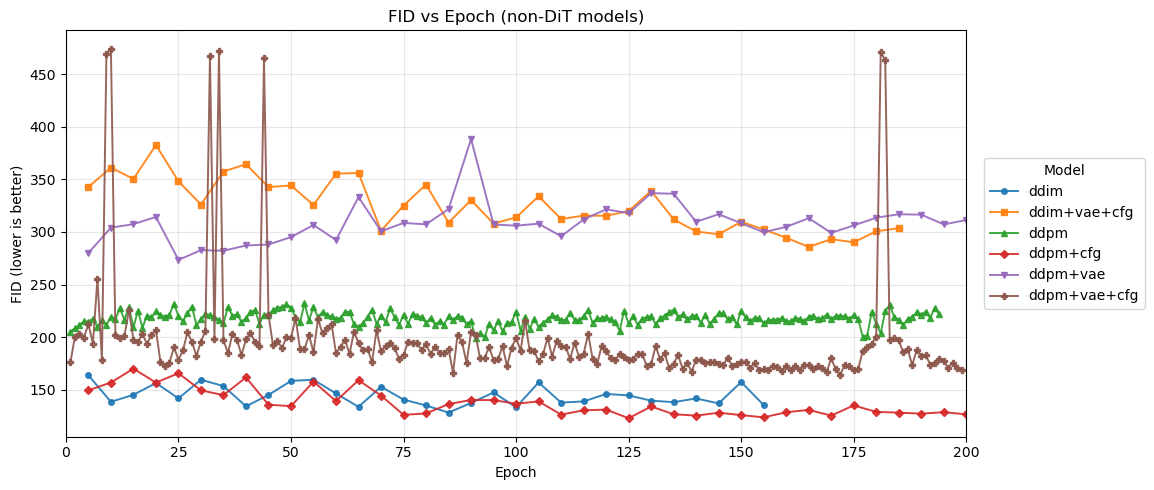

In [55]:
# non-dit models
plot_fid_for_models(
    non_dit_models,
    title="FID vs Epoch (non-DiT models)",
    xlim=(0, 200),   # adjust if you like
)


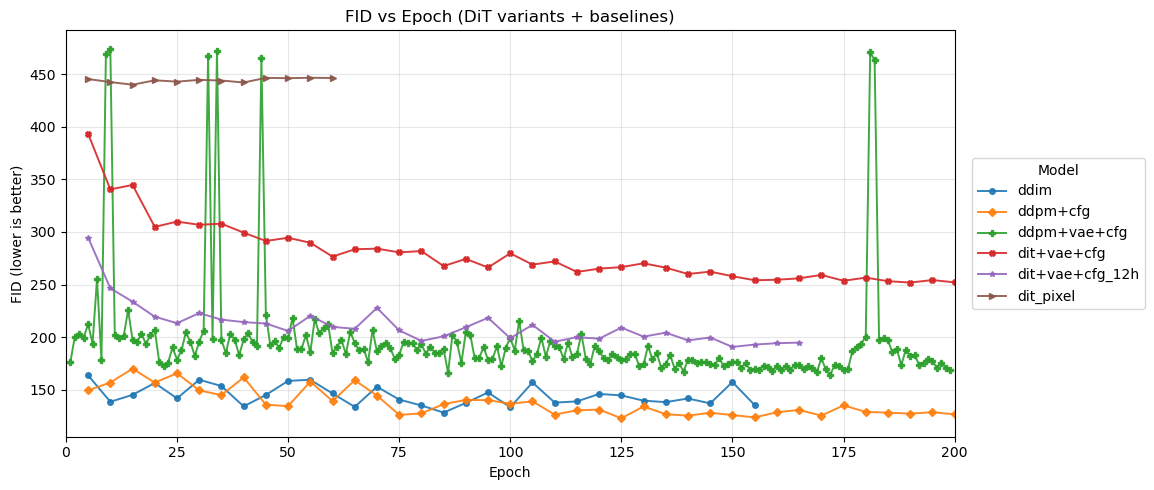

In [56]:
# DIT models and baselines:
plot_fid_for_models(
    dit_plus_baselines,
    title="FID vs Epoch (DiT variants + baselines)",
    xlim=(0, 200),
)


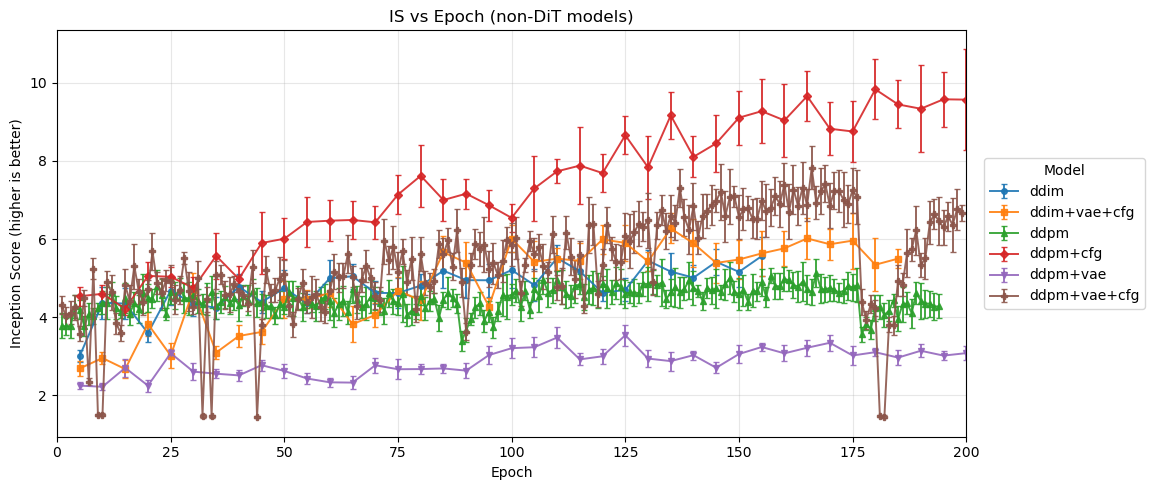

In [57]:
#IS for non-dit
plot_is_for_models(
    non_dit_models,
    title="IS vs Epoch (non-DiT models)",
    xlim=(0, 200),
)


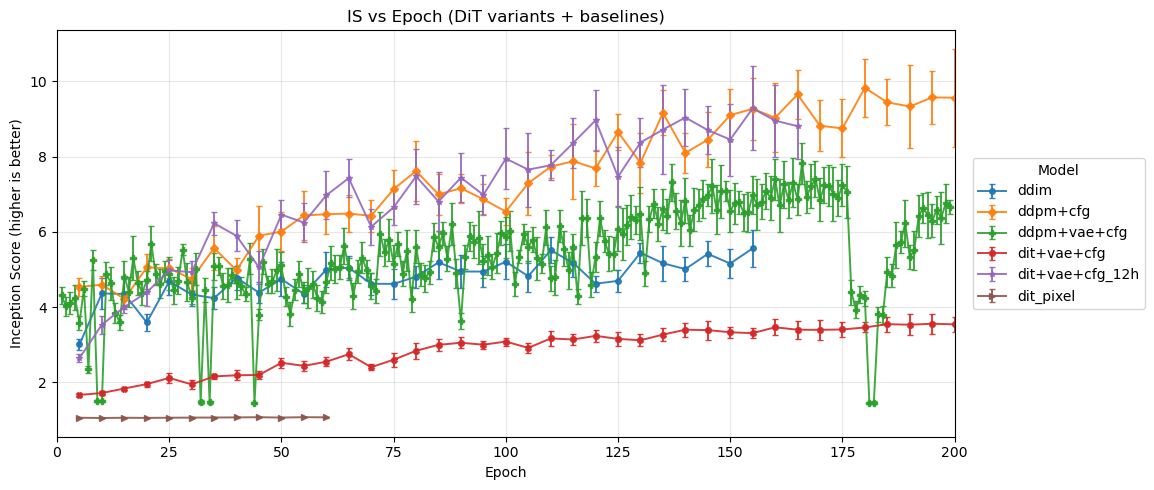

In [58]:
# IS for dit and beste comparison models
plot_is_for_models(
    dit_plus_baselines,
    title="IS vs Epoch (DiT variants + baselines)",
    xlim=(0, 200),
)



# Inference FID and IS Scores

In [9]:
from collections import OrderedDict

run_paths = OrderedDict({
    # Juhi's runs 
    "ddpm+vae+cfg": [
        "Diffusion-F25DL_Project/diffusion_inference/c2jh219z",
    ],
    "ddpm": [
        "Diffusion-F25DL_Project/diffusion_inference/fx82tr4y",
    ],

    # Divya's multi-block runs
    "ddpm+vae": [
        "Diffusion-F25DL_Project/diffusion_inference/x6ve6f0q",
    ],
    "ddpm+cfg": [
        "Diffusion-F25DL_Project/diffusion_inference/svd3je9f",
    ],

    # Sumeet's single-run models
    "ddim": [
        "Diffusion-F25DL_Project/diffusion_inference/m58tl4f3",
    ],
    "ddim+vae+cfg": [
        "Diffusion-F25DL_Project/diffusion_inference/s15s0whd",
    ],
    "dit+vae+cfg_8heads": [
        "Diffusion-F25DL_Project/diffusion_inference/g6zkcqlf",
    ],
    "dit+vae+cfg_12heads": [
        "Diffusion-F25DL_Project/diffusion_inference/lg0iqu82",
    ],
})


In [10]:
import re
api = wandb.Api()

def fetch_inference_metrics(path, verbose=False):
    """Return a dict with final FID, IS_mean, IS_std for a single inference run."""
    run = api.run(path)

    # Get full history
    hist = run.history(samples=1000)

    if verbose:
        print(f"\n=== columns for {path} ===")
        print(hist.columns.tolist())

    # Helper to find a column name by regex
    def find_col(regex_list):
        for col in hist.columns:
            for pattern in regex_list:
                if re.search(pattern, col, re.IGNORECASE):
                    return col
        return None

    fid_col     = find_col([r"\bfid\b"])
    is_mean_col = find_col([r"inception[_/ ]score[_/ ]mean", r"inception_score_mean", r"is_mean", r"\bis_mean\b"])
    is_std_col  = find_col([r"inception[_/ ]score[_/ ]std", r"inception_score_std", r"is_std", r"\bis_std\b"])

    if verbose:
        print("  fid_col:", fid_col)
        print("  is_mean_col:", is_mean_col)
        print("  is_std_col:", is_std_col)

    # If there is no FID or IS column at all, skip
    if fid_col is None and is_mean_col is None:
        return None

    # Pick the last row where any metric exists
    metric_cols = [c for c in [fid_col, is_mean_col] if c is not None]
    df = hist.dropna(subset=metric_cols)
    if df.empty:
        return None
    last = df.iloc[-1]

    return {
        "fid":      float(last[fid_col])     if fid_col is not None else None,
        "is_mean":  float(last[is_mean_col]) if is_mean_col is not None else None,
        "is_std":   float(last[is_std_col])  if (is_std_col is not None and not pd.isna(last[is_std_col])) else None,
    }

In [11]:

rows = []
for model_name, paths in run_paths.items():
    for path in paths:
        if not path:
            continue
        metrics = fetch_inference_metrics(path, verbose=False)
        if metrics is None:
            print(f"No metrics found for {model_name} ({path})")
            continue
        row = {"model": model_name}
        row.update(metrics)
        rows.append(row)

inference_df = pd.DataFrame(rows)
print(inference_df)

                 model         fid    is_mean    is_std
0         ddpm+vae+cfg  189.526566   5.793369  0.304286
1                 ddpm  150.034500   4.448161  0.100573
2             ddpm+vae  241.916260   3.322337  0.115503
3             ddpm+cfg   94.228218  11.212237  0.461725
4                 ddim  152.095581   5.590729  0.247583
5         ddim+vae+cfg  168.243973   5.288347  0.147946
6   dit+vae+cfg_8heads  313.291565   1.775430  0.019019
7  dit+vae+cfg_12heads  167.679092   6.107328  0.204465


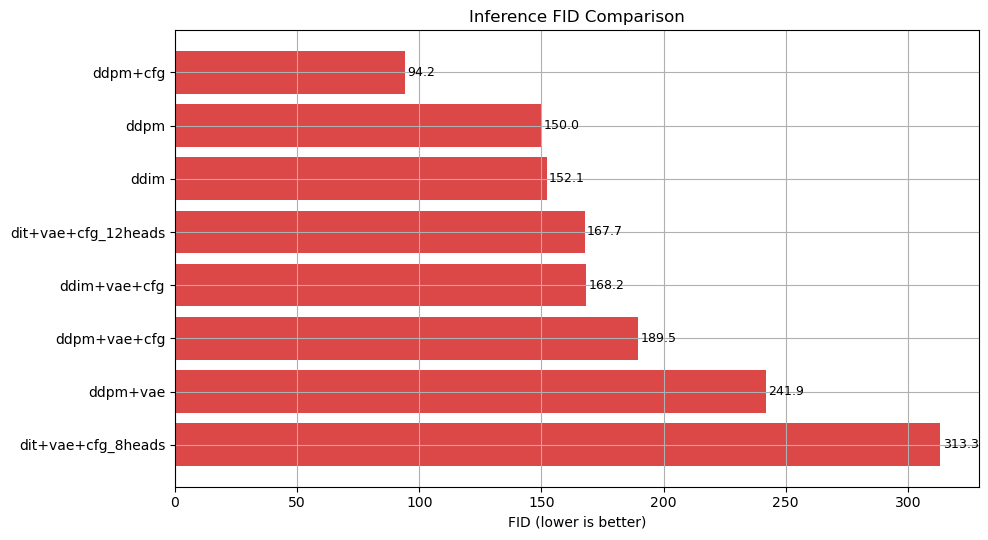

In [12]:
# Sort by FID ascending (best at top)
fid_df = inference_df.dropna(subset=["fid"]).sort_values("fid")

plt.figure(figsize=(10,5.5))
plt.barh(fid_df["model"], fid_df["fid"], color="tab:red", alpha=0.85)

plt.xlabel("FID (lower is better)")
plt.title("Inference FID Comparison")

# Add value labels on the bars
for i, (m, v) in enumerate(zip(fid_df["model"], fid_df["fid"])):
    plt.text(v + 1, i, f"{v:.1f}", va="center", fontsize=9)

plt.gca().invert_yaxis()  # best model at the top
plt.tight_layout()
plt.grid()
plt.show()


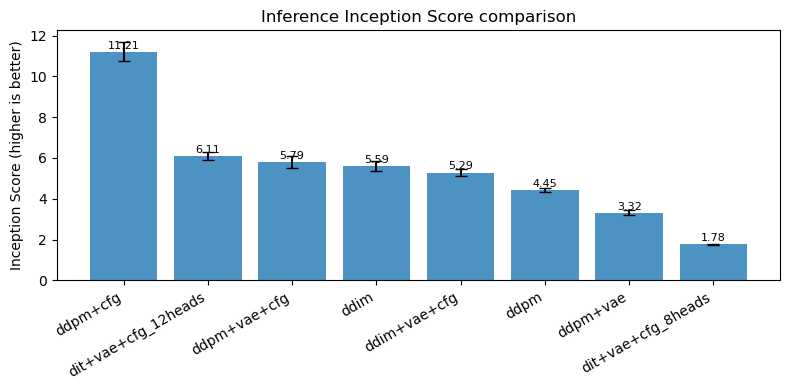

In [13]:
is_df = inference_df.dropna(subset=["is_mean"]).sort_values("is_mean", ascending=False)

plt.figure(figsize=(8,4))
plt.bar(
    is_df["model"],
    is_df["is_mean"],
    yerr=is_df["is_std"],
    capsize=4,
    color="tab:blue",
    alpha=0.8,
)
plt.ylabel("Inception Score (higher is better)")
plt.title("Inference Inception Score comparison")

for i, (m, v) in enumerate(zip(is_df["model"], is_df["is_mean"])):
    plt.text(i, v + 0.05, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [17]:
is_std_df = inference_df.dropna(subset=["is_mean"])[["model", "is_std"]]
print(is_std_df)

                 model    is_std
0         ddpm+vae+cfg  0.304286
1                 ddpm  0.100573
2             ddpm+vae  0.115503
3             ddpm+cfg  0.461725
4                 ddim  0.247583
5         ddim+vae+cfg  0.147946
6   dit+vae+cfg_8heads  0.019019
7  dit+vae+cfg_12heads  0.204465


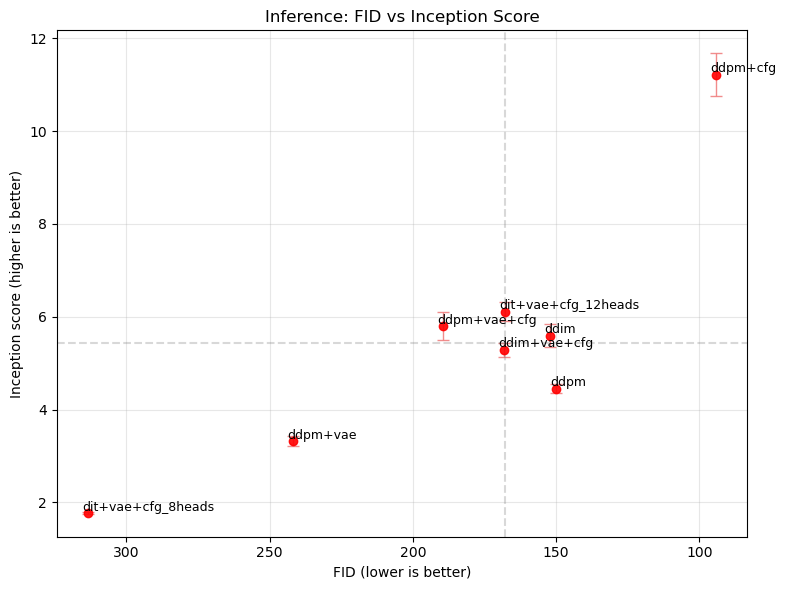

In [73]:
scatter_df = inference_df.dropna(subset=["fid", "is_mean"]).copy()

plt.figure(figsize=(8, 6))

if "is_std" in scatter_df.columns and scatter_df["is_std"].notna().any():
    plt.errorbar(
        scatter_df["fid"],
        scatter_df["is_mean"],
        yerr=scatter_df["is_std"],
        fmt="o",
        color="red", 
        ecolor="lightcoral",  
        capsize=4,
        linewidth=1.0,
        alpha=0.9,
    )
else:
    plt.scatter(
        scatter_df["fid"],
        scatter_df["is_mean"],
        s=60,
        color="red", 
        edgecolor="black",
        alpha=0.9,
    )

# annotate points
for _, row in scatter_df.iterrows():
    plt.text(
        row["fid"] + 2,   # small offset
        row["is_mean"] + 0.05,
        row["model"],
        fontsize=9,
    )

# Helpful reference lines (median FID / IS)
plt.axvline(scatter_df["fid"].median(),  color="gray", linestyle="--", alpha=0.3)
plt.axhline(scatter_df["is_mean"].median(), color="gray", linestyle="--", alpha=0.3)

plt.xlabel("FID (lower is better)")
plt.ylabel("Inception score (higher is better)")
plt.title("Inference: FID vs Inception Score")

# switch to top-left
plt.gca().invert_xaxis()

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
